In [104]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

from bs4 import BeautifulSoup
import urllib
import json
import numpy as np

import hashlib
import sqlite3
import urllib2
import time
import pickle as cPickle
import re
from collections import Counter

import sys
reload(sys)
sys.setdefaultencoding('utf-8')


import wget

import os.path

import graph_tool.all as gt

MaDB = "patents.db"


In [107]:
def CreateMD(mydb):
    g = gt.Graph()
    vprop_int = g.new_vertex_property("int")
    
    MDText = "# Mapping \n\n"
    conn = sqlite3.connect(mydb)
    cursor = conn.cursor()
    print mydb
    Request =  'SELECT p_id, p_date FROM patents ORDER BY p_date'
    #print Request
    cursor.execute(Request)
    DB = []
    for row in cursor:
        DB.append(row[0])
        v = g.add_vertex()
    print len(DB)
    Request =  'SELECT p_id, p_title, p_date, p_abstract, p_backward, p_forward FROM patents ORDER BY p_date'
    #print Request
    cursor.execute(Request)

    for row in cursor:
        s = DB.index(row[0])
        
        TopFW = [x for x in list(set(row[5].split(", "))) if x in DB]
        TopBW = [x for x in list(set(row[4].split(", "))) if x in DB]
        #for FW in TopFW:
        #    i = DB.index(FW)
        #    g.add_edge(g.vertex(s), g.vertex(i))
        #for BW in TopBW:
        #    i = DB.index(BW)
        #    g.add_edge(g.vertex(i), g.vertex(s))
            

    
    state = gt.minimize_blockmodel_dl(g)
    pr = gt.pagerank(g)
    A = pr.get_array()
    M = max(A)
    #state.draw(output="state.draw.png")
    
    b = state.get_blocks()
    for k in range(len(DB)):
        vprop_int[g.vertex(k)] = b[k]
    
    pos = gt.fruchterman_reingold_layout(g,a=10,r = 500,circular = False)
    gt.graph_draw(g, pos, 
           output_size=(1000, 1000),
           #vertex_color=[1,1,1,0],
           vertex_fill_color=vprop_int,
           vertex_size=gt.prop_to_size(pr, mi=5, ma=15),vorder=pr,
           #vertex_size=1, edge_pen_width=1.2, 
           output="patents_pagerank.png")
    
    # PageRank
    PR = []
    for k in range(len(DB)):
        PR.append(prank[k])
    ind = np.argpartition(PR, -20)[-20:]
    
    Request =  'SELECT p_id, p_title, p_date, p_abstract, p_backward, p_forward FROM patents ORDER BY p_date'
    cursor.execute(Request)
    Top20 = "# Highest Pages\n"
    
    
    for row in cursor:
        p = DB.index(row[0])
        AB = row[3].replace("Abstract","").strip()
        AB1 = "\n"+AB.split("\n\n")[0][:1000]+"\n"
        
        MDText += "## "+row[1].replace("Google Patents","").replace("-","").replace("\n","").strip()+" -- (_"+row[0]+"_)\n\n"
        Top20 += "* (_"+row[0]+"_) "+row[1].replace("Google Patents","").replace("-","").replace("\n","").strip()
        
        MDText += "### Info:\n* Date: "+row[2]+"\n"
        Top20 += " - on "+row[2]+" - pagerank:"+str(int(1000*A[p]/M))+"\n"
        
        MDText += "* Pagerank: "+str(int(1000*A[p]/M))+"\n"
        MDText += "* Modularity class: "+str( b[p] )+"\n"
        MDText += "* Backward: "+row[4]+"\n"
        MDText += "* Forward: "+row[5]+"\n\n"
        MDText += "### Abstract:\n "+AB1+"\n"
            

    conn.close()
    
    MDText += "\n"+Top20
        
    f = open("summary.md","w") 
    f.write(MDText)
    f.close() 

    return MDText,pr,g,b,DB,A

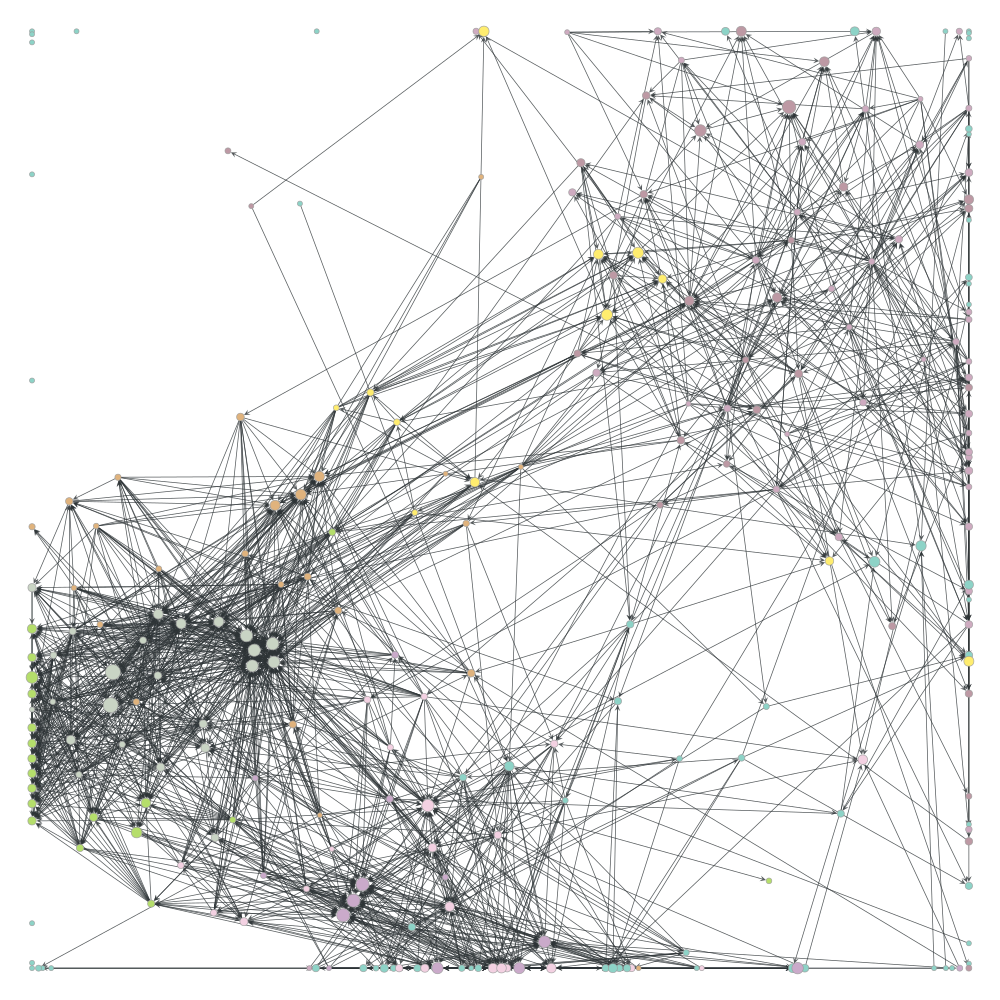

In [108]:
MDText,pr,g,b,DB,prank = CreateMD(MaDB)

In [106]:

print ind
for i in ind:
    print PR[i]